# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety

import codecs
from collections import defaultdict # mozesz uzyc zamiast zwyklego slownika, rozwaz wplyw na czas obliczen
import math
import re
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# mozesz uzyc do obliczania najbardziej podobnych tekstow zamiast liczenia "na piechote"
# ale pamietaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /home/barto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# definiujemy potrzebne zmienne

PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykułów

def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]
    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }

def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]
        return {x['news_id']: x for x in parsed_entries}

news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]
    return user_id, history

def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]
        return dict(entries)

users_history = get_users_history()
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'
print(len(users_history))

50000


## Część 2. - TF-IDF

In [5]:
from typing import Literal

# normalizujemy teksty na potrzeby dalszego przetwarzania


def preprocess_text(text: str) -> list[str]:
    # zamieniamy wszystkie ciagi bialych znakow na pojedyncze spacje
    text = " ".join(text.split())
    # usuwamy znaki interpunkcyjne
    for p in punctuation:
        text = text.replace(p, "")
    # usuwamy wszystkie liczby
    for n in "0123456789":
        text = text.replace(n, "")
    # podmieniamy wszystkie wielkie litery
    text = text.lower()
    # dzielimy na tokeny
    tokens = set(text.split())
    # usuwamy stopwords
    tokens -= STOPWORDS

    return list(tokens)


def stem_texts(
    corpus: list[str],
    method: Literal["Lancaster", "Porter", "Snowball"] = "Lancaster",
) -> list[list[str]]:
    # stemmer = ...  # przetestuj rozne stemmery
    match method:
        case "Lancaster":
            stemmer = LancasterStemmer()
        case "Porter":
            stemmer = PorterStemmer()
        case "Snowball":
            stemmer = SnowballStemmer(language="english")
    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]


texts = [news[news_id]["abstract"] for news_id in news_ids]
stemmed_texts = stem_texts(texts, method="Porter")
print(len(stemmed_texts))

51282


In [6]:
# porownajmy teksty przed i po przetworzeniu

print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

brian realli team group schmetzer close think special good thing


In [7]:
# tworzymy liste wszystkich slow w korpusie

def get_all_words_sorted(corpus: list[list[str]]) -> list[str]:
    # generujemy posortowana alfabetycznie liste wszystkich slow (tokenow)
    all_tokens = set()
    for text in corpus:
        all_tokens |= set(text)
    return sorted(all_tokens)

wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

41884


In [8]:
# obliczamy liczbe tekstow, w ktorych wystapilo kazde ze slow
# pamietaj, ze jesli slowo wystapilo w danym tekscie wielokrotnie, to liczymy je tylko raz


def get_document_frequencies(
    corpus: list[list[str]],
    wordlist: list[str],
) -> defaultdict[str, int]:
    # return {word -> count}
    f = defaultdict(lambda: 0)
    for text in corpus:
        for word in set(text):
            f[word] += 1
    return f


document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [9]:
# obliczamy liczbe wystapien kazdego slowa w kazdym tekscie


def get_term_frequencies(
    corpus: list[list[str]],
    news_indices: list[str],
) -> defaultdict[str, defaultdict[str, int]]:
    # return {news_id -> {word -> count}}
    f = defaultdict(lambda: defaultdict(lambda: 0))
    for news_id, text in zip(news_indices, corpus):
        for word in text:
            f[news_id][word] += 1
    return f


term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [10]:
# sprawdzmy wyniki

term_frequency[news_ids[2]]

defaultdict(<function __main__.get_term_frequencies.<locals>.<lambda>.<locals>.<lambda>()>,
            {'brian': 1,
             'realli': 1,
             'team': 1,
             'group': 1,
             'schmetzer': 1,
             'close': 1,
             'think': 1,
             'special': 1,
             'good': 1,
             'thing': 1})

In [11]:
# obliczamy metryke tf_idf
from math import log


def calculate_tf_idf(
    term_frequency: defaultdict[str, defaultdict[str, int]],
    document_frequency: defaultdict[str, int],
    corpus_size: int,
) -> defaultdict[str, defaultdict[str, float]]:
    # return {news_id -> {word -> tf_idf}}
    tf_idf = defaultdict(lambda: defaultdict(lambda: 0.0))
    for news_id in term_frequency:
        for word in term_frequency[news_id]:
            tf_idf[news_id][word] = term_frequency[news_id][word] * log(corpus_size / document_frequency[word])
    return tf_idf


tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [12]:
# sprawdzmy wyniki

tf_idf[news_ids[2]]

defaultdict(<function __main__.calculate_tf_idf.<locals>.<lambda>.<locals>.<lambda>()>,
            {'brian': 5.624739267315748,
             'realli': 4.853630545286091,
             'team': 3.078678194374417,
             'group': 4.261685870235309,
             'schmetzer': 9.458800731274183,
             'close': 3.9244235881453897,
             'think': 4.360459856758821,
             'special': 4.765161897298483,
             'good': 4.0427003290697625,
             'thing': 4.111693200556713})

## Część 3. - Podobieństwo tekstów

In [13]:
# obliczmy odleglosc miedzy dwoma artykulami
# przetestuj rozne metryki odleglosci i wybierz najlepsza
from math import sqrt

GREATER_IS_BETTER = {"euclidean": False, "cosine": True}


def calculate_distance(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    id1: str,
    id2: str,
    method: Literal["euclidean", "cosine"] = "euclidean",
) -> float:
    match method:
        case "euclidean":
            d = sqrt(sum((tf_idf[id1][w] - tf_idf[id2][w]) ** 2 for w in tf_idf[id1] if w in tf_idf[id2]))
        case "cosine":
            dot = sum(tf_idf[id1][w] * tf_idf[id2][w] for w in tf_idf[id1] if w in tf_idf[id2])
            norm1 = sqrt(sum(tf_idf[id1][w] ** 2 for w in tf_idf[id1]))
            norm2 = sqrt(sum(tf_idf[id2][w] ** 2 for w in tf_idf[id2]))
            if norm1 == 0 or norm2 == 0:
                d = -float('inf')
            else:
                d = dot / (norm1 * norm2)
        case _:
            raise ValueError(f"Unknown method: {method}")

    return d


calculate_distance(tf_idf, news_ids[2], news_ids[1], method="cosine")

0.015428919391646242

In [14]:
# funkcja pomocnicza do wyswietlania artykulow
def print_news_entry(n_id: str, corpus: dict[str, dict[str, str]]):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')

print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [15]:
# wyznaczmy k najpodobniejszych tekstow do danego
# pamietaj o odpowiedniej kolejnosci sortowania w zaleznosci od wykorzystanej metryki
# pamietaj, zeby wsrod podobnych tekstow nie bylo danego
import heapq


def get_k_most_similar_news(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    n_id: str,
    k: int,
    method="cosine",
) -> list[str]:
    ids = [id for id in tf_idf if id != n_id]
    if GREATER_IS_BETTER[method]:
        return heapq.nlargest(k, ids, key=lambda id: calculate_distance(tf_idf, id, n_id, method))
    return heapq.nsmallest(k, ids, key=lambda id: calculate_distance(tf_idf, id, n_id, method))


def print_k_most_similar_news(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    n_id: str,
    k: int,
    corpus: dict[str, dict[str, str]],
):
    similar = get_k_most_similar_news(tf_idf, n_id, k)
    print_news_entry(n_id, corpus)
    print(f"\n{k} most similar:")
    for s_id in similar:
        print_news_entry(s_id, corpus)


print_k_most_similar_news(tf_idf, news_ids[42337], 5, news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

In [16]:
len(list(tf_idf.keys()))

48600

## Część 4. - Profile użytkowników

In [28]:
# oblicz srednia z wektorow tf-idf artykulow o zadanych id-kach
def calculate_average_vector(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    news_ids: list[str],
) -> dict[str, float]:
    m = defaultdict(lambda: 0)
    c = defaultdict(lambda: 0)
    for id in news_ids:
        for w in tf_idf[id]:
            m[w] += tf_idf[id][w]
            c[w] += 1
    for w in m:
        m[w] /= c[w]

    return m


# wykorzystaj powyzsza funkcje, by policzyc wektor kazdego uzytkownika
def calculate_users_vectors(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    users_history: dict[str, list[str]],
) -> dict[str, dict[str, float]]:
    return {uid: calculate_average_vector(tf_idf, nids) for uid, nids in users_history.items()}


user_vectors = calculate_users_vectors(tf_idf, users_history)

In [29]:
# sprawdz wyliczony profil dla przykladowego uzytkownika
print(sorted([(k,v) for k,v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('hors', 13.372424018068802), ('licens', 12.217793287999156), ('ditch', 11.02288129639139), ('nitc', 10.845095092394073), ('livewir', 10.845095092394073), ('phaeton', 10.845095092394073), ('catera', 10.845095092394073), ('reatta', 10.845095092394073), ('culiacán', 10.845095092394073), ('shantnazaryan', 10.845095092394073), ('nightfli', 10.845095092394073), ('thrillseek', 10.845095092394073), ('guilin', 10.845095092394073), ('tahoka', 10.845095092394073), ('alwyn', 10.845095092394073), ('teed', 10.151947911834128), ('nustar', 10.151947911834128), ('shelterinplac', 10.151947911834128), ('limousin', 10.151947911834128), ('blackwood', 10.151947911834128), ('pallbear', 10.151947911834128), ('hailston', 10.151947911834128), ('hull', 9.746482803725963), ('lp', 9.746482803725963), ('westward', 9.746482803725963), ('retard', 9.746482803725963), ('sheikh', 9.746482803725963), ('skylight', 9.746482803725963), ('whizz', 9.746482803725963), ('irrig', 9.746482803725963), ('board', 9.732418654985903

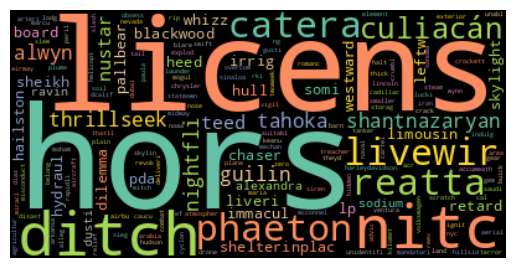

In [30]:
# skorzystajmy ze znanej juz biblioteki, by to lepiej zwizualizowac
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_vector(user_vectors[test_users[0]])

## Część 5. - Rekomendacje dla użytkowników

In [31]:
# wykorzystujac wektory tresci i profile uzytkownikow,
#   wygeneruj liste k artykulow najlepiej dopasowanych do uzytkownika
#   pamietaj o odsianiu artykulow, ktore uzytkownik juz kliknal


def recommend(
    tf_idf: defaultdict[str, defaultdict[str, float]],
    user_id: str,
    users_history: dict[str, list[str]],
    k: int,
    method="cosine",
) -> list[str]:
    user_history = users_history[user_id]
    i = 0

    while True:
        recs = defaultdict(lambda: 0)
        count = defaultdict(lambda: 0)
        for nid in user_history:
            similar = get_k_most_similar_news(tf_idf, nid, k + i, method)
            for sid in similar:
                if sid not in user_history:
                    recs[sid] += calculate_distance(tf_idf, nid, sid, method)
                    count[sid] += 1
        if len(recs) >= k:
            break
        i += 1

    for id in recs:
        recs[id] /= count[id]

    recs = sorted(recs, key=lambda id: recs[id], reverse=GREATER_IS_BETTER[method])[:k]

    return recs


# dla wybranego uzytkownika, korzystajac z juz zaimplementowanych funkcji,
#   pokaz jego historie, profil (wordcloud) i rekomendacje

print("User history")
for n_id in users_history[test_users[0]]:
    print_news_entry(n_id, news)

print("User recommendations")
for n_id in recommend(tf_idf, test_users[0], users_history, k=5):
    print_news_entry(n_id, news)

User history
id: N58936
	title: Beloved grandfather's body pulled from collapsed Hard Rock hotel
	text: A family holding vigil outside the site of the Hard Rock hotel construction collapse received the news they hoped they'd never hear.
id: N15919
	title: Saddleridge fire calms down, heavy rains on East Coast
	text: A new storm system is developing in the southern Plains and will move east over the next few days bringing a threat of flooding to the South with rain and gusty winds.
id: N11917
	title: JetBlue Plane Makes Emergency Landing at JFK Airport
	text: The plane landed safely in NYC Sunday night.
id: N2153
	title: Iran alleges foreign government behind 'treacherous' ship attack
	text: Iran said Monday a foreign government was behind what it alleges was a "treacherous" attack on a tanker off Saudi Arabia last week, as it released pictures of its damaged hull. But the state-owned NITC denied reports the alleged attack had originated from Saudi soil.
id: N55312
	title: Why are most 

## Część 6. - Ocena jakości

In [ ]:
# jaccard index to metryka podobienstwa zbiorow, lekko ja zmodyfikujemy
# przeciecie wektorow to minimum po kazdej wspolrzednej
# unia wektorow to maksimum po kazdej wspolrzednej
# jaccard index to iloraz sum tych dwoch wartosci


def jaccard(v1: dict[str, float], v2: dict[str, float]) -> float:
    n, d = 0, 0
    for w in set(v1) | set(v2):
        if w in v1 and w in v2:
            n += min(v1[w], v2[w])
            d += max(v1[w], v2[w])
        elif w in v1:
            n += 0
            d += v1[w]
        elif w in v2:
            n += 0
            d += v2[w]
    return n / d

In [48]:
# dla kazdego uzytkownika wygeneruj k-elementowa rekomendacje
# policz jaccard index miedzy wektorem uzytkownika a srednim wektorem elementow z rekomendacji
# porownaj wyniki dla dwoch roznych k i dwoch roznych metryk podobienstwa
user_id = test_users[0]

for k in (5, 8):
    for method in ("cosine", "euclidean"):
        jac = jaccard(
            user_vectors[user_id],
            calculate_average_vector(tf_idf, recommend(tf_idf, user_id, users_history, k, method)),
        )
        print(f"k={k}, method={method}, jaccard={jac:.4f}\n")

k=5, method=cosine, jaccard=0.0623

k=5, method=euclidean, jaccard=0.0130

k=8, method=cosine, jaccard=0.1059

k=8, method=euclidean, jaccard=0.0506

